Librerias

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from skopt.callbacks import VerboseCallback

import os
import json
from joblib import Parallel, delayed

Lectura de Archivos

In [2]:
pet_train   = pd.read_csv('Data/train/train.csv')
pet_test    = pd.read_csv('Data/test/test.csv')
pet_colors  = pd.read_csv('Data/color_labels.csv')
pet_breeds  = pd.read_csv('Data/breed_labels.csv')
pet_states  = pd.read_csv('Data/state_labels.csv')

Funcion "Prelim" para analisis basico del dataframe

In [3]:
def prelim(df):
    analisis_preliminar = pd.DataFrame()

    analisis_preliminar['Campo'] = df.columns
    analisis_preliminar['Orden'] = range(1,len(analisis_preliminar)+1)
    analisis_preliminar['Total'] = (~df.isna()).sum().values
    analisis_preliminar['Unicos'] = df.nunique().values
    analisis_preliminar['Nulos'] = df.isna().sum().values

    return analisis_preliminar

Comienzo a Explorar la informacion

In [4]:
prelim(pet_train)

,Campo,Orden,Total,Unicos,Nulos
0,Type,1,14993,2,0
1,Name,2,13736,9060,1257
2,Age,3,14993,106,0
3,Breed1,4,14993,176,0
4,Breed2,5,14993,135,0
5,Gender,6,14993,3,0
6,Color1,7,14993,7,0
7,Color2,8,14993,7,0
8,Color3,9,14993,6,0
9,MaturitySize,10,14993,4,0


In [5]:
i = 0
for field in pet_train.columns:
    print(f'Field: {field}, orden {i}\nUnique Values: {pet_train[field].nunique()}')
    print(f'Nulls: {pet_train[field].isna().sum()}')
    print(pet_train[field].value_counts(dropna=False).nlargest(5))
    print(f'\n')
    i+=1


Field: Type, orden 0
Unique Values: 2
Nulls: 0
1    8132
2    6861
Name: Type, dtype: int64


Field: Name, orden 1
Unique Values: 9060
Nulls: 1257
NaN        1257
Baby         66
Lucky        64
No Name      54
Brownie      54
Name: Name, dtype: int64


Field: Age, orden 2
Unique Values: 106
Nulls: 0
2     3503
1     2304
3     1966
4     1109
12     967
Name: Age, dtype: int64


Field: Breed1, orden 3
Unique Values: 176
Nulls: 0
307    5927
266    3634
265    1258
299     342
264     296
Name: Breed1, dtype: int64


Field: Breed2, orden 4
Unique Values: 135
Nulls: 0
0      10762
307     1727
266      599
265      321
299      138
Name: Breed2, dtype: int64


Field: Gender, orden 5
Unique Values: 3
Nulls: 0
2    7277
1    5536
3    2180
Name: Gender, dtype: int64


Field: Color1, orden 6
Unique Values: 7
Nulls: 0
1    7427
2    3750
3     947
5     884
6     684
Name: Color1, dtype: int64


Field: Color2, orden 7
Unique Values: 7
Nulls: 0
0    4471
7    3438
2    3313
5    1128
6    10

Cambio de las variables categoricas de Int a Category

Mapeos inmediatos, valores en la documentacion del dataset en Kaggle

In [6]:
mapping = {1: 'Perro', 2: 'Gato'}
pet_train['Type'] = pet_train['Type'].map(mapping).astype('category')

mapping = {1: 'Male', 2 : 'Female', 3 : 'Mixed'}
pet_train['Gender'] = pet_train['Gender'].map(mapping).astype('category')

mapping = {1 : 'Small', 2 : 'Medium', 3 : 'Large', 4 : 'Extra Large', 0 : 'Not Specified'}
pet_train['MaturitySize'] = pet_train['MaturitySize'].map(mapping).astype('category').cat.as_ordered()

mapping = {1 : 'Short', 2 : 'Medium', 3 : 'Long', 0 : 'Not Specified'}
pet_train['FurLength'] = pet_train['FurLength'].map(mapping).astype('category').cat.as_ordered()

mapping = {1: 'Yes', 2: 'No', 3: 'Not Sure'}
pet_train['Vaccinated'] = pet_train['Vaccinated'].map(mapping).astype('category')
pet_train['Dewormed'] = pet_train['Dewormed'].map(mapping).astype('category')
pet_train['Sterilized'] = pet_train['Sterilized'].map(mapping).astype('category')

mapping = {1 : 'Healthy', 2 : 'Minor Injury', 3 : 'Serious Injury', 0 : 'Not Specified'}
pet_train['Health'] = pet_train['Health'].map(mapping).astype('category').cat.as_ordered()
del(mapping)

Mapeos a partir de datos de otros archivos accesorios

In [7]:
mapping = dict(zip(pet_breeds['BreedID'],pet_breeds['BreedName']))
mapping[0] = np.nan
mapping[307] = 'Mezcla'
pet_train['Breed1'] = pet_train['Breed1'].map(mapping).astype('category')
pet_train['Breed2'] = pet_train['Breed2'].map(mapping).astype('category')
del(mapping, pet_breeds)

In [8]:
mapping = dict(zip(pet_colors['ColorID'],pet_colors['ColorName']))
mapping[0] = np.nan
pet_train['Color1'] = pet_train['Color1'].map(mapping).astype('category')
pet_train['Color2'] = pet_train['Color2'].map(mapping).astype('category')
pet_train['Color3'] = pet_train['Color3'].map(mapping).astype('category')
del(mapping, pet_colors)

In [9]:
mapping = dict(zip(pet_states['StateID'],pet_states['StateName']))
mapping[0] = np.nan
pet_train['State'] = pet_train['State'].map(mapping).astype('category')
del(mapping, pet_states)

Feature Engineering

In [10]:
#limpiar nombres invalidos
nonames = ['2 Kittens','2 Puppies','3 Cute Kittens','3 Kittens','4 Kitten','4 Kittens','4 Puppies','6 Puppies','B1','B2','Babies','Cute Puppies','Cute Pups','Kitten For Adoption','Kittens For Adoption','Lovely Puppies','Nameless','No Name','No Name Yet','No Names Yet','Noname','Not Yet Named','Puppies For Adoption','Puppy 1','Puppy 2','Three Kittens','TWO KITTENS','Unnamed']
pet_train.loc[pet_train['Name'].isin(nonames), 'Name'] = np.nan

pet_train['has_name'] = ~pet_train['Name'].isna()
pet_train['popular_name'] = pet_train['Name'].isin(pet_train['Name'].value_counts(dropna=False)[0:100].index.values)

In [11]:
vc = pd.DataFrame(pet_train['RescuerID'].value_counts())

bins = [0, 2, 10, 20, 50, 100, float('inf')]
labels = ['<2','<10','<20', '<50', '<100', '>100']

vc['AgencySize'] = pd.cut(vc['RescuerID'], bins=bins, labels=labels, right=False)

vc = vc.reset_index()
vc = vc.rename(columns={"RescuerID": "RescuedQuantity","index": "RescuerID"})

pet_train = pet_train.merge(vc[['RescuerID','AgencySize']], on='RescuerID', how='left')

del(bins, field, i, labels, vc)

In [12]:
razas = {'Mezcla','Domestic Short Hair','Domestic Long Hair','Domestic Medium Hair','Mixed Breed'}
pet_train['Raza'] = ~pet_train['Breed1'].isin(razas) & ~pet_train['Breed2'].isin(razas)

In [13]:
pet_train['Colores'] = 3 - (pet_train['Color1'].isna() * 1 + pet_train['Color2'].isna() * 1 + pet_train['Color3'].isna() * 1)

In [14]:
prelim(pet_train)

,Campo,Orden,Total,Unicos,Nulos
0,Type,1,14993,2,0
1,Name,2,13736,9060,1257
2,Age,3,14993,106,0
3,Breed1,4,14988,175,5
4,Breed2,5,4231,134,10762
5,Gender,6,14993,3,0
6,Color1,7,14993,7,0
7,Color2,8,10522,6,4471
8,Color3,9,4389,5,10604
9,MaturitySize,10,14993,4,0


Proceso de JSONs de Sentimientos

In [15]:
def get_sentiment(filename):

    path = 'Data/train_sentiment'
    with open(os.path.join(path, filename), encoding="utf8") as ruta:
        row_json = json.load(ruta)
    row = {}

    row['PetID'] = filename.replace('.json', '')
    
    try:
        magnitudes, scores = [], []
        for sentence in row_json['sentences']:
            magnitudes.append(sentence['sentiment']['magnitude'])
            scores.append(sentence['sentiment']['score'])
        sentences_df = pd.DataFrame({'magnitude': magnitudes, 'score': scores})
        sentences_df['score'] = sentences_df['magnitude'] * sentences_df['score']
        epsilon = np.finfo(np.float32).eps
        sentences_df['score'] = sentences_df['magnitude'] / (sentences_df['magnitude'].sum() + epsilon)
        row['sentence_score_mean'] = sentences_df['score'].mean()
        row['sentence_score_var'] = sentences_df['score'].var()
    except:
        row['sentence_score_mean'] = np.nan
        row['sentence_score_var'] = np.nan 

    try:
        row['document_magnitude'] = row_json['documentSentiment']['magnitude']
        row['document_score'] = row_json['documentSentiment']['score']
    except:
        row['document_magnitude'] = np.nan
        row['document_score'] = np.nan
    
    return row

In [16]:
train_sentiment_df = pd.DataFrame(Parallel(n_jobs=-1, verbose=2)(
    delayed(get_sentiment)(filename) for filename in os.listdir(
        'Data/train_sentiment/')))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 3560 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 8088 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 13928 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 14442 out of 14442 | elapsed:   13.8s finished


In [17]:
pet_train = pd.merge(pet_train, train_sentiment_df, how='left', on='PetID')

Proceso de Metadata de las imagenes

In [18]:
def get_metadata_features(pet_id):
    """
    Collects the following features from the image metadata for profile images.
    
    1. Image resolution.
    2. Top 3 dominant colors by score.
    """
    json_path = 'Data/train_metadata/{}-1.json'.format(pet_id)
    image_path = 'Data/train_images/{}-1.jpg'.format(pet_id)
    
    if not os.path.exists(json_path):
        # Test sample with no profile picture
        if os.path.exists('Data/train_metadata/{}-2.json'.format(pet_id)):
            json_path = 'Data/train_metadata/{}-2.json'.format(pet_id)
            image_path = 'Data/train_images/{}-2.jpg'.format(pet_id)
        else:
            return
    
    row = {}
    
    row['PetID'] = pet_id
    
    with open(json_path, encoding="utf8") as ruta:
        row_json = json.load(ruta)
    
    try:
        image = Image.open(image_path)
        row['img_width'], row['img_height'] = image.size
    except:
        row['img_width'], row['img_height'] = np.nan, np.nan
    
    try:
        colors = row_json['imagePropertiesAnnotation']['dominantColors']['colors']
        reds, greens, blues, scores = [], [], [], []
        for color in colors:
            reds.append(color['color'].get('red', 0))
            greens.append(color['color'].get('green', 0))
            blues.append(color['color'].get('blue', 0))
            scores.append(color.get('score', 0))
        colors_df = pd.DataFrame({'red': reds, 'green': greens, 'blue': blues, 'score': scores})
        row.update(dict(zip(['img_color_1_red', 'img_color_1_green', 'img_color_1_blue',
                             'img_color_2_red', 'img_color_2_green', 'img_color_2_blue',
                             'img_color_3_red', 'img_color_3_green', 'img_color_3_blue'],
                            colors_df.sort_values('score', ascending=False).iloc[:3, :-1].values.ravel())))
    except:
        row.update(dict(zip(['img_color_1_red', 'img_color_1_green', 'img_color_1_blue',
                             'img_color_2_red', 'img_color_2_green', 'img_color_2_blue',
                             'img_color_3_red', 'img_color_3_green', 'img_color_3_blue'], [np.nan] * 9)))
    
    return row


In [19]:
train_metadata_rows = Parallel(n_jobs=-1, verbose=2)(
    delayed(get_metadata_features)(pet_id) for pet_id in pet_train['PetID'])
train_metadata_df = pd.DataFrame([row for row in train_metadata_rows if row is not None])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1032 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 8808 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 14648 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 14993 out of 14993 | elapsed:   11.8s finished


In [20]:
pet_train = pd.merge(pet_train, train_metadata_df, how='left', on='PetID')

Imagenes (procesadas aparte)

In [21]:
train_img_df = pd.read_parquet('Procesado/train_images.parquet', engine='pyarrow')

In [22]:
pet_train = pd.merge(pet_train, train_img_df, how='left', on='PetID')

Texto (procesado aparte)

In [23]:
train_texto_df = pd.read_parquet('Procesado/train_text.parquet', engine='pyarrow')

In [24]:
pet_train = pd.merge(pet_train, train_texto_df, how='left', on='PetID')

Modelo

No estandarizamos porque lightGBM no necesita

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
pet_train = pet_train.drop(['Name','RescuerID','Description','PetID'], axis = 1)

In [27]:
X = pet_train.drop('AdoptionSpeed', axis=1)
y = pet_train['AdoptionSpeed']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [29]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(n_estimators=500)

In [30]:
search_params = {
    'learning_rate': (0.001, 0.1, 'log-uniform'),
    'max_depth': (3, 13),
    'num_leaves': (5, 50),
    'min_child_samples': (5, 30),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

ten fold cross val
optimizacion de algunos hiperparametros

In [31]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold

bayes_cv = BayesSearchCV(
    model,
    search_params,
    scoring='accuracy',
    n_iter=11,
    cv=KFold(n_splits=10, shuffle=True),
    n_jobs=-1,
    verbose=0,
    refit=True,
    random_state=42
)

In [32]:
def print_progress(res):
    print("Puntaje actual: {:.4f}. Mejor puntaje hasta ahora: {:.4f}".format(
        res['target'], bayes_cv.best_score_
    ))

In [33]:
bayes_cv.fit(X_train, y_train, callback=VerboseCallback(50))

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 1149.0403
Function value obtained: -0.4316
Current minimum: -0.4316
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 999.2001
Function value obtained: -0.4327
Current minimum: -0.4327
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 309.1859
Function value obtained: -0.4212
Current minimum: -0.4327
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 1124.5255
Function value obtained: -0.4202
Current minimum: -0.4327
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 1450.5810
Function v

BayesSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
              estimator=LGBMClassifier(n_estimators=500), n_iter=11, n_jobs=-1,
              random_state=42, scoring='accuracy',
              search_spaces={'colsample_bytree': (0.5, 1.0, 'uniform'),
                             'learning_rate': (0.001, 0.1, 'log-uniform'),
                             'max_depth': (3, 13), 'min_child_samples': (5, 30),
                             'num_leaves': (5, 50),
                             'subsample': (0.5, 1.0, 'uniform')})

In [34]:
print("Mejor puntaje:", bayes_cv.best_score_)
print("Mejores hiperparámetros:", bayes_cv.best_params_)

Mejor puntaje: 0.43554296609015386
Mejores hiperparámetros: OrderedDict([('colsample_bytree', 0.8997767208035865), ('learning_rate', 0.007517239253342655), ('max_depth', 8), ('min_child_samples', 23), ('num_leaves', 46), ('subsample', 0.8585155755799185)])


In [35]:
pd.DataFrame(bayes_cv.cv_results_).to_csv('bayesiana.csv')

In [36]:
best_model = LGBMClassifier(**bayes_cv.best_params_, n_estimators=500)
best_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8997767208035865,
               learning_rate=0.007517239253342655, max_depth=8,
               min_child_samples=23, n_estimators=500, num_leaves=46,
               subsample=0.8585155755799185)

In [37]:
test_probs = pd.Series(best_model.predict_proba(X_test).argmax(axis=1),
                       name="AdoptionSpeed", index=X_test.index)

In [38]:
resultado = pd.concat([y_test,test_probs],axis=1)
resultado.columns = ['Real' , 'Prediccion']
resultado['Acierto'] = resultado['Real'] == resultado['Prediccion']

resultado.to_csv('resultado.csv')

In [39]:
resultado['Acierto'].mean()

0.43663850600266785

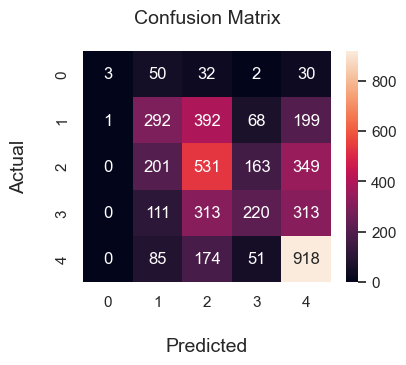

In [40]:
conf_matrix = confusion_matrix(y_test, test_probs)

plt.figure(figsize=(4,3), dpi=100)
sns.set(font_scale = 1)

ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )

ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()